In [1]:
#Step 1: Import Libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Model
import matplotlib.pyplot as plt

In [3]:
#Step 2: Load and Preprocess MNIST Data
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 28*28).astype('float32')  # Flatten images
x_train = (x_train - 127.5) / 127.5  # Normalize to [-1, 1]

print("Data shape:", x_train.shape)

Data shape: (60000, 784)


In [5]:
#Step 3: Build Generator
def make_generator():
    model = Sequential()
    model.add(layers.Input(shape=(100,)))  # Input layer
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(784, activation='tanh'))  # Output shape for MNIST
    return model

generator = make_generator()
generator.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 784)                 │         101,136 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 114,064 (445.56 KB)

 Trainable params: 114,064 (445.56 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
#Step 4: Build Discriminator
def make_discriminator():
    model = Sequential()
    model.add(layers.Input(shape=(784,)))  # Input layer
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

discriminator = make_discriminator()
discriminator.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,609 (393.00 KB)

 Trainable params: 100,609 (393.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#Step 5: Build GAN Model
# Freeze discriminator only for GAN training
discriminator.trainable = False

noise_input = layers.Input(shape=(100,))
fake_image = generator(noise_input)
gan_output = discriminator(fake_image)

gan = Model(noise_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Unfreeze discriminator for standalone training
discriminator.trainable = True

gan.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 784)                 │         114,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │         100,609 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 214,673 (838.57 KB)

 Trainable params: 214,673 (838.57 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#Step 6: Function to Generate and Show Images
def generate_and_show_images(generator, epoch, num_images=5):
    noise = np.random.normal(0, 1, (num_images, 100))
    gen_images = generator.predict(noise, verbose=0)
    gen_images = 0.5 * gen_images + 0.5  # Rescale to [0,1]

    plt.figure(figsize=(10,2))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(gen_images[i].reshape(28,28), cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Generated Images at Epoch {epoch}")
    plt.show()


In [13]:
#Step 7: Train the GAN
def train_gan(epochs=5000, batch_size=64, display_interval=500):
    for epoch in range(1, epochs+1):
        # ---------------------
        # Train Discriminator
        # ---------------------
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_images = x_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict(noise, verbose=0)

        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        # Train Generator via GAN
        # ---------------------
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_labels = np.ones((batch_size, 1))
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, valid_labels)
        discriminator.trainable = True

        # ---------------------
        # Display progress and images
        # ---------------------
        if epoch % display_interval == 0:
            print(f"Epoch {epoch} | D Loss: {d_loss[0]:.4f}, D Acc: {d_loss[1]*100:.2f}% | G Loss: {g_loss:.4f}")
            generate_and_show_images(generator, epoch)


Epoch 500 | D Loss: 0.0369, D Acc: 98.95% | G Loss: 4.6293


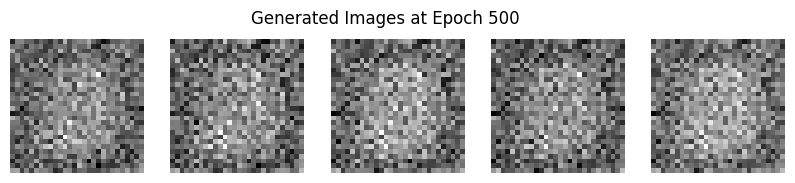

Epoch 1000 | D Loss: 0.0393, D Acc: 99.09% | G Loss: 4.7824


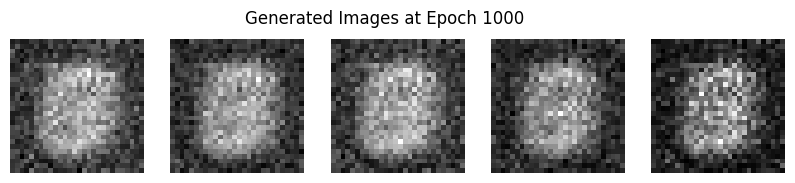

Epoch 1500 | D Loss: 0.0671, D Acc: 98.17% | G Loss: 4.6338


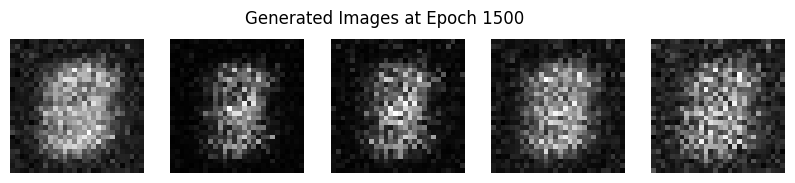

Epoch 2000 | D Loss: 0.0870, D Acc: 97.32% | G Loss: 4.6913


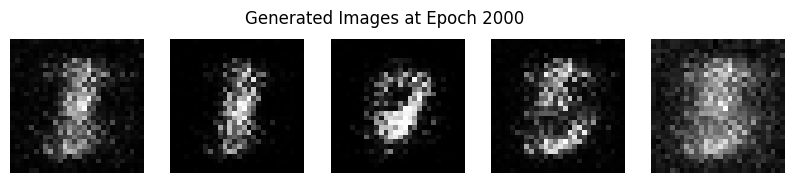

Epoch 2500 | D Loss: 0.1072, D Acc: 96.50% | G Loss: 4.6451


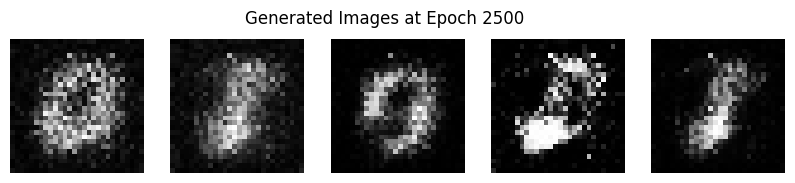

Epoch 3000 | D Loss: 0.1232, D Acc: 95.81% | G Loss: 4.6294


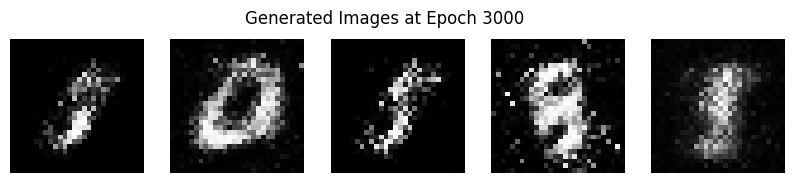

Epoch 3500 | D Loss: 0.1303, D Acc: 95.48% | G Loss: 4.6366


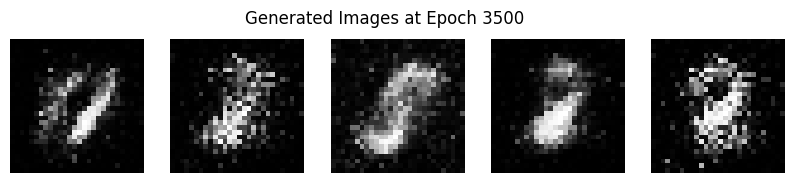

Epoch 4000 | D Loss: 0.1363, D Acc: 95.21% | G Loss: 4.7097


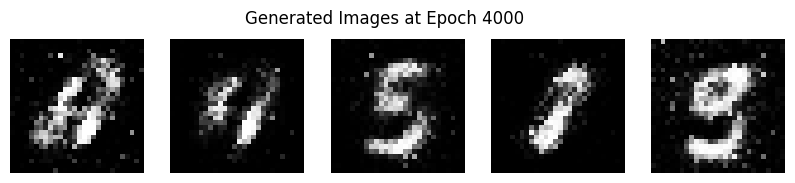

Epoch 4500 | D Loss: 0.1429, D Acc: 94.90% | G Loss: 4.7531


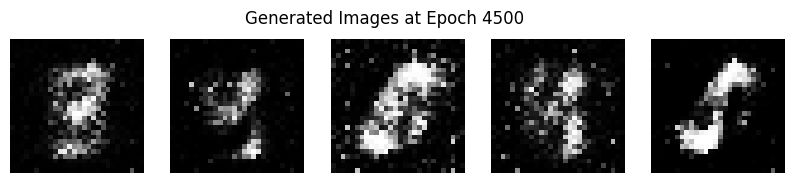

Epoch 5000 | D Loss: 0.1511, D Acc: 94.56% | G Loss: 4.7571


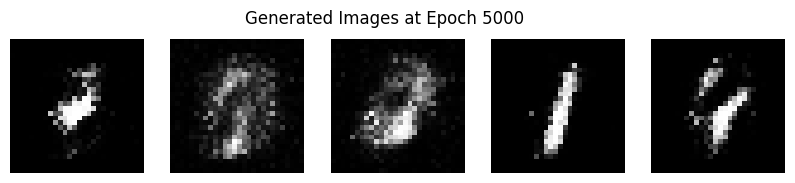

In [15]:
#Step 8: Start Training
train_gan(epochs=5000, batch_size=64, display_interval=500)